# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_fscore_support as score
)
import matplotlib.pyplot as plt


penguin = load_penguins().dropna()


KeyError: "['gentoo'] not found in axis"

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

--- kNN (k=3) ---
Confusion Matrix:
 [[43  1  0]
 [ 0 20  0]
 [ 0  0 36]]
Accuracy: 0.99
Precision: [1.         0.95238095 1.        ]
Recall: [0.97727273 1.         1.        ]
F1-Score: [0.98850575 0.97560976 1.        ]
AUC: 1.0


--- kNN (k=7) ---
Confusion Matrix:
 [[44  0  0]
 [ 0 20  0]
 [ 0  0 36]]
Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1-Score: [1. 1. 1.]
AUC: 1.0


--- Decision Tree (max_depth=3) ---
Confusion Matrix:
 [[44  0  0]
 [ 0 20  0]
 [ 2  0 34]]
Accuracy: 0.98
Precision: [0.95652174 1.         1.        ]
Recall: [1.         1.         0.94444444]
F1-Score: [0.97777778 1.         0.97142857]
AUC: 0.9842472342472343


--- Decision Tree (max_depth=5) ---
Confusion Matrix:
 [[44  0  0]
 [ 0 20  0]
 [ 2  0 34]]
Accuracy: 0.98
Precision: [0.95652174 1.         1.        ]
Recall: [1.         1.         0.94444444]
F1-Score: [0.97777778 1.         0.97142857]
AUC: 0.9847883597883599


--- kNN (k=3) ---
Confusion Matrix:
 [[43  1  0]
 [ 0 20  0]
 [ 0  0 36

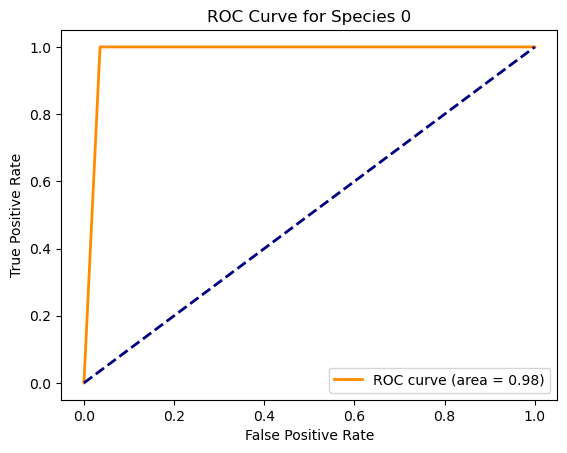

In [6]:

le = LabelEncoder()
penguins['species'] = le.fit_transform(penguins['species'])  # Encode 'species'

# Split features and target
X = penguins.drop(columns=['species'])
y = penguins['species']

# Binarize the target variable for ROC calculations
y_binarized = label_binarize(y, classes=[0, 1, 2])

# Train-Test Split with stratification
X_train, X_test, y_train, y_test, y_train_binarized, y_test_binarized = train_test_split(
    X, y, y_binarized, test_size=0.3, random_state=42, stratify=y
)

# Preprocessing pipeline
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['sex', 'island']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Define models
models = {
    'kNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'kNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'Decision Tree (max_depth=3)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Decision Tree (max_depth=5)': DecisionTreeClassifier(max_depth=5, random_state=42)
}

# Evaluate models
results = {}

for name, model in models.items():
    # Create pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    # Train the model
    clf.fit(X_train, y_train)
    # Predictions and probabilities
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = score(y_test, y_pred, average=None)
    auc_score = roc_auc_score(y_test_binarized, y_proba, multi_class="ovr")
    # Store results
    results[name] = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score
    }

    # Print results
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc_score)
    print("\n")

# Plot ROC for a specific species (e.g., species 0)
species = 0  
model_name = 'kNN (k=3)'  
fpr, tpr, _ = roc_curve(y_test_binarized[:, species], clf.predict_proba(X_test)[:, species])
roc_auc = auc(fpr, tpr)


<positron-console-cell-9>:29: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


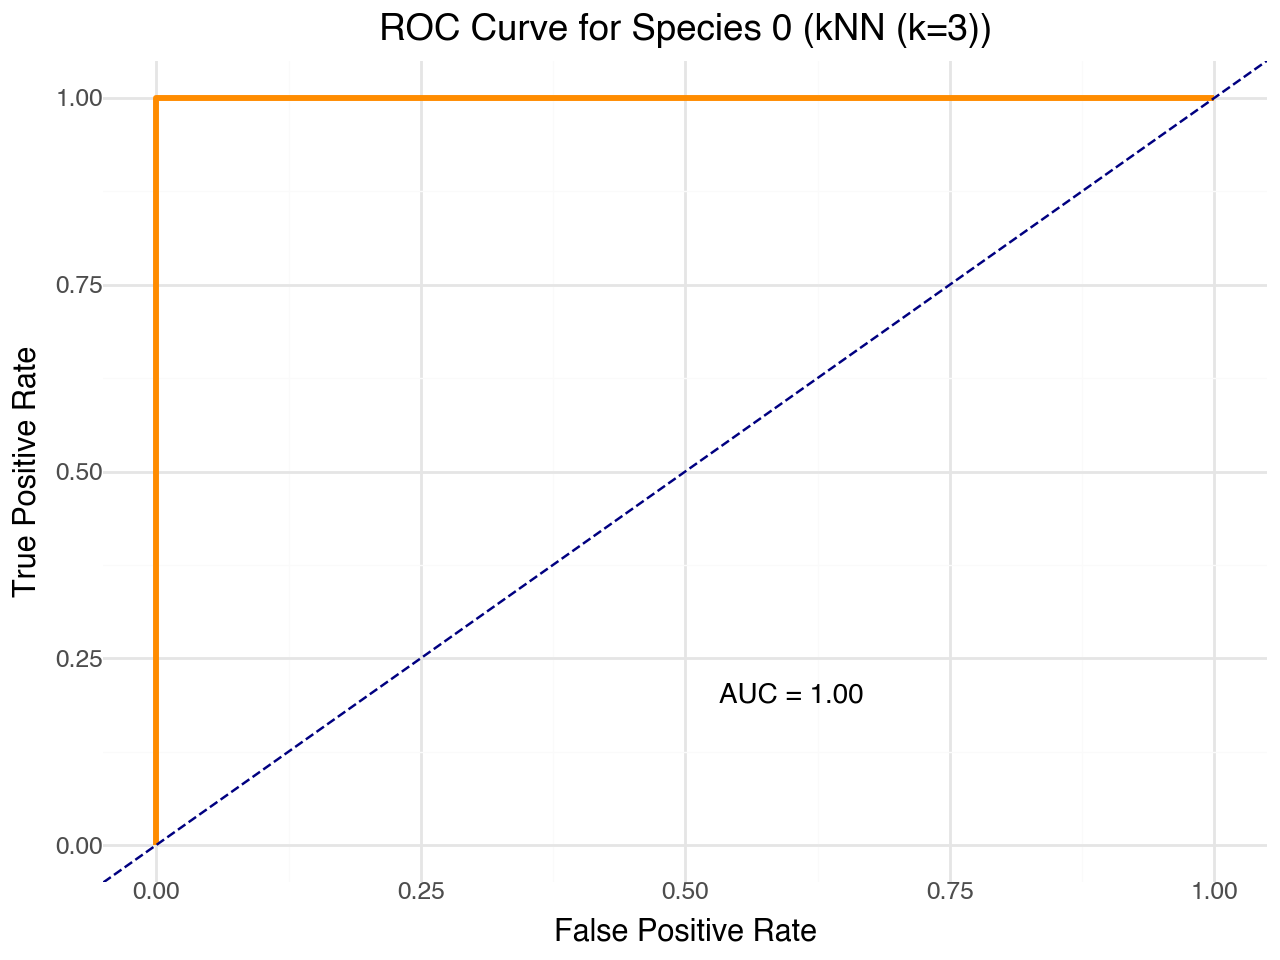

/opt/anaconda3/lib/python3.12/pprint.py:632: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


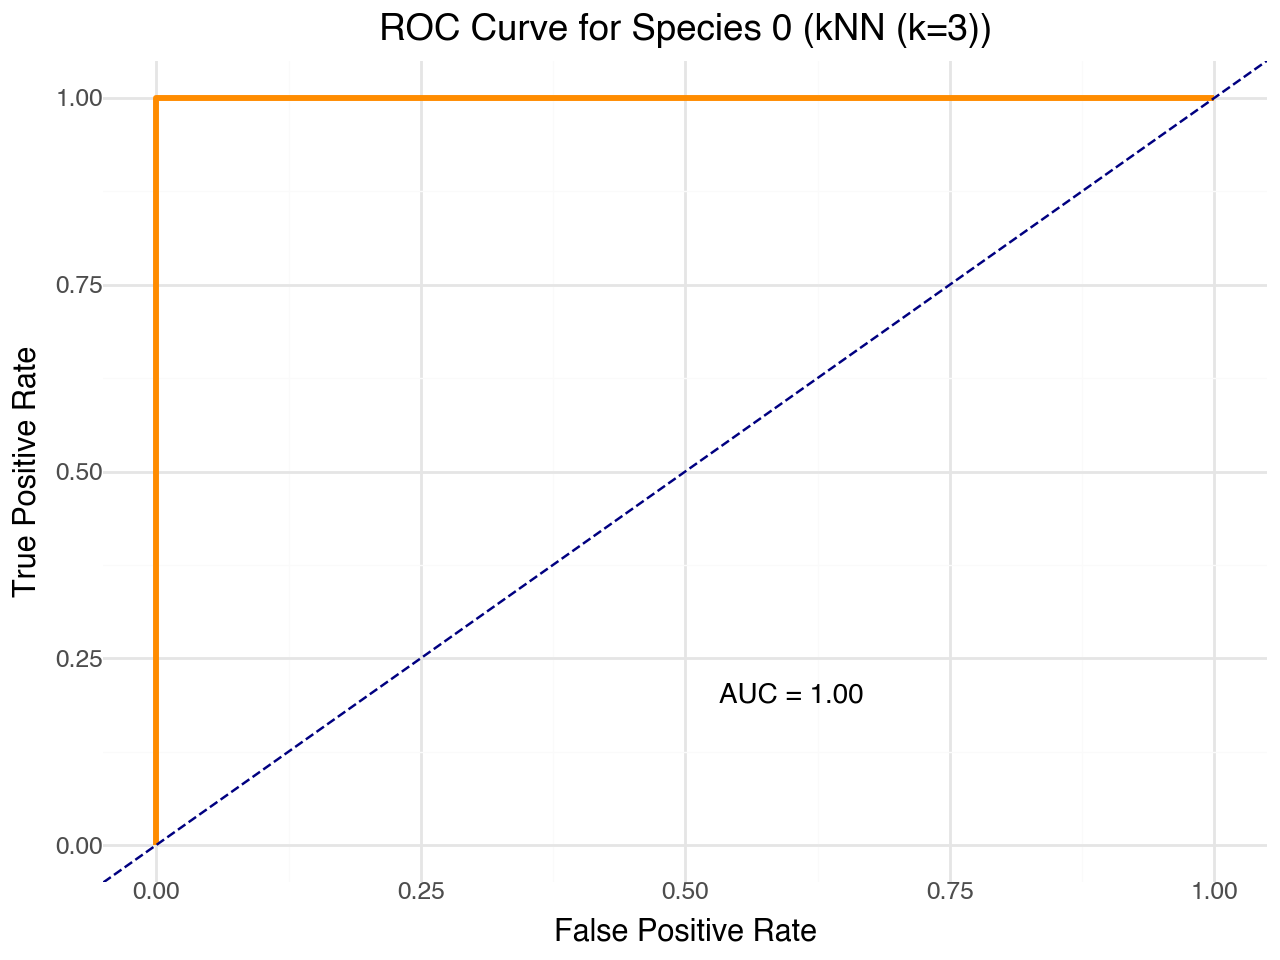

In [9]:
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_minimal, annotate

# Create a DataFrame for plotnine
roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

# Plot using plotnine
roc_plot = (
    ggplot(roc_data, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='darkorange', size=1.2) +
    geom_abline(intercept=0, slope=1, color='navy', linetype='dashed') +
    annotate(
        'text',
        x=0.6, y=0.2,  # Position of the annotation
        label=f"AUC = {roc_auc:.2f}",
        size=10,
        color='black'
    ) +
    labs(
        title=f'ROC Curve for Species {species} ({model_name})',
        x='False Positive Rate',
        y='True Positive Rate'
    ) +
    theme_minimal()
)

print(roc_plot)

